In [1]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image
! pip install ip_adapter
from ip_adapter import IPAdapter

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

ModuleNotFoundError: No module named 'ip_adapter'

In [1]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"
device = "cuda"

In [25]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [26]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


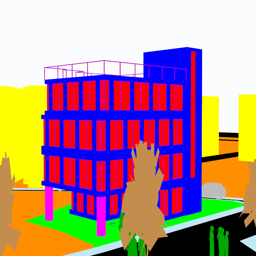

In [27]:
# read image prompt
image = Image.open("/segment.png")
image.resize((256, 256))

In [32]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [10]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

NameError: name 'ip_model' is not defined

## Image-to-Image

In [11]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

NameError: name 'ip_model' is not defined

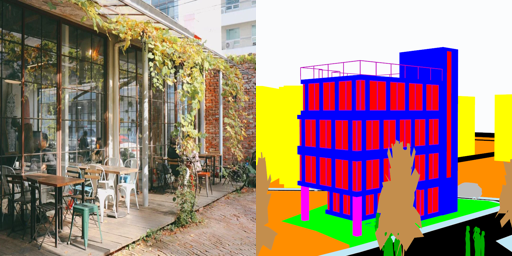

In [13]:
# read image prompt
image = Image.open("/성수1.webp")
g_image = Image.open("/segment.png")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [14]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

NameError: name 'pipe' is not defined

In [15]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

NameError: name 'ip_model' is not defined

## Inpainting

In [16]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

NameError: name 'pipe' is not defined

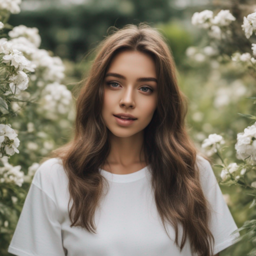

In [ ]:
# read image prompt
image = Image.open("assets/images/girl.png")
image.resize((256, 256))

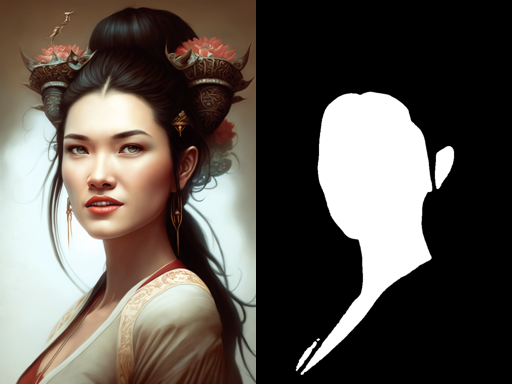

In [ ]:
masked_image = Image.open("assets/inpainting/image.png").resize((512, 768))
mask = Image.open("assets/inpainting/mask.png").resize((512, 768))
image_grid([masked_image.resize((256, 384)), mask.resize((256, 384))], 1, 2)

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/35 [00:00<?, ?it/s]

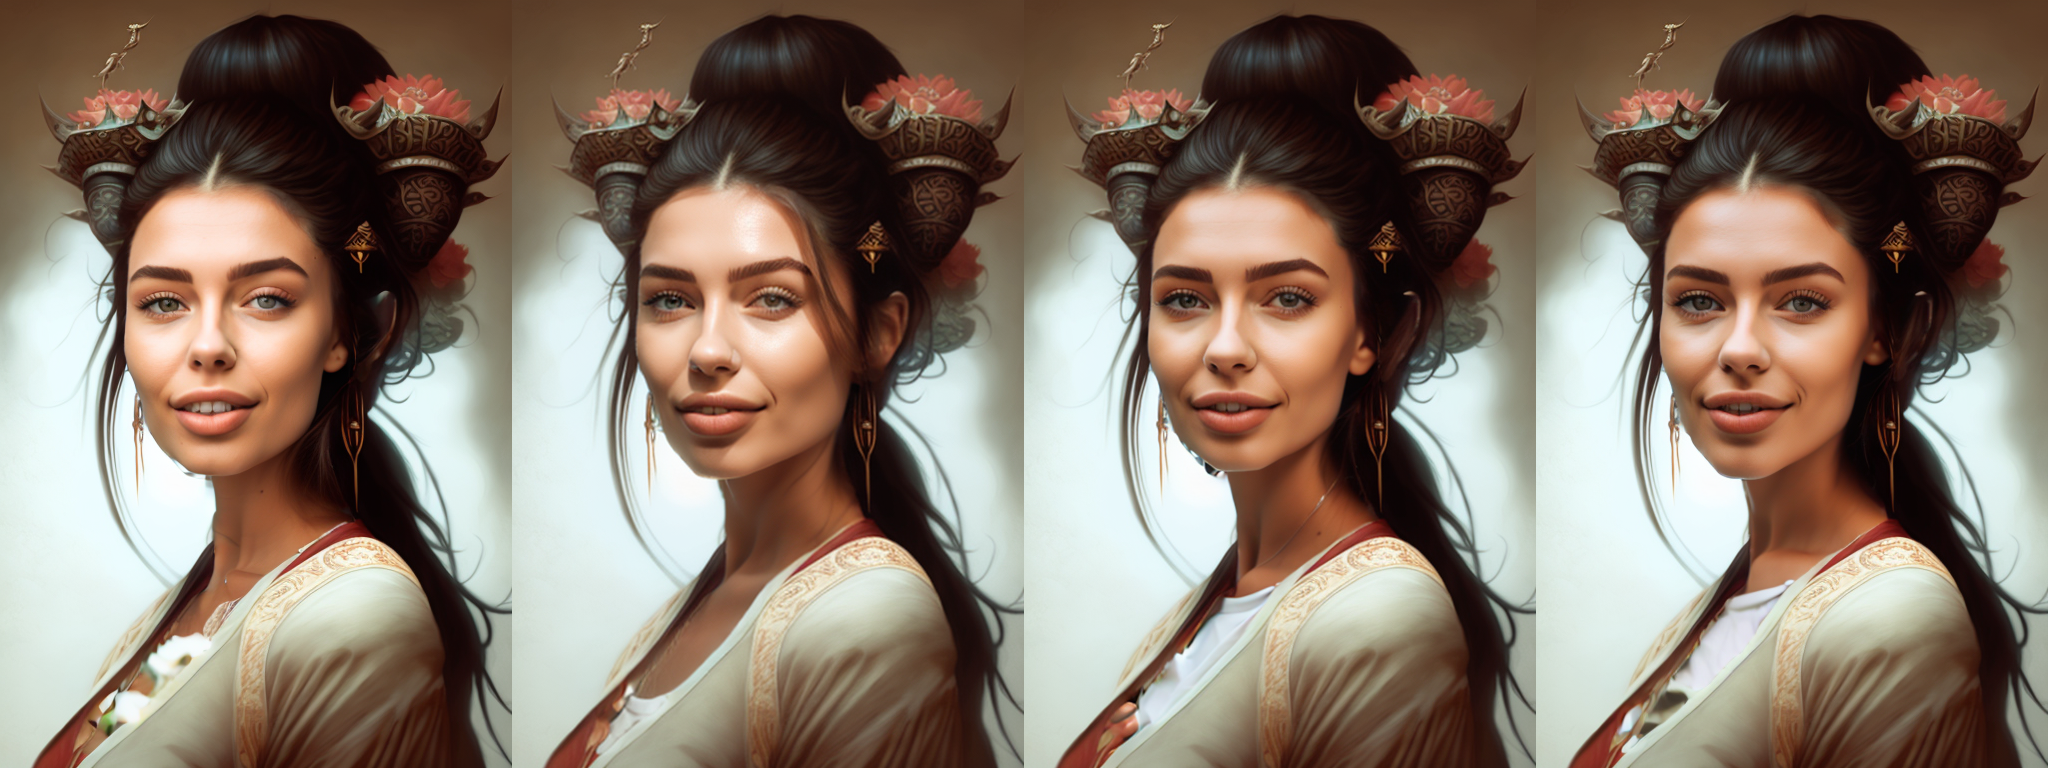

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, )
grid = image_grid(images, 1, 4)
grid